**1. Data Quality Checks**

In [ ]:
# Validate VIN formats

# Using PySpark UDF to validate VIN Format

import re
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

# VIN must be 17 characters and exclude I, O, Q

VIN_REGEX = re.compile(r"^[A-HJ-NPR-Z0-9]{17}$")

def is_valid_vin(vin: str) -> bool:
    if vin is None:
        return False
    vin = vin.upper().strip()
    return bool(VIN_REGEX.fullmatch(vin))

# Register as UDF
is_valid_vin_udf = udf(is_valid_vin, BooleanType())


In [ ]:
# Check for missing critical fields

# The idea here is we define a strict schema for inspections json and transform them into table.
# Any missing field will be filled Null
# Additional column "missing_field_flag" will be flagged as True in case there is a missing field in the row


from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("Inspection Schema Validation").getOrCreate()

# Define schema (enforcing structure, allow nullable so we can flag them)
inspection_schema = StructType([
    StructField("inspection_id", StringType(), True),
    StructField("vehicle_vin", StringType(), True),
    StructField("inspector_id", StringType(), True),
    StructField("inspection_date", TimestampType(), True),
    StructField("location_lat", DoubleType(), True),
    StructField("location_lon", DoubleType(), True),
    StructField("status", StringType(), True),
    StructField("duration_minutes", IntegerType(), True)
])

json_path = "s3://pave_ai_storage/bronze/inspections.json"
df = spark.read.schema(inspection_schema).json(json_path)

# Add `missing_field_flag` column — True if any field is null
fields = inspection_schema.fieldNames()
missing_condition = None
for field in fields:
    cond = col(field).isNull()
    missing_condition = cond if missing_condition is None else (missing_condition | cond)

df = df.withColumn("missing_field_flag", when(missing_condition, lit(True)).otherwise(lit(False)))

# Filter the column "missing_field_flag" to find records with missing fields:
df_missing = df.filter(col("missing_field_flag") == True)



In [ ]:
# Identify duplicate inspections

# Check if there are any duplication inspection_id

from pyspark.sql.functions import *

df_dups = df.groupBy("inspection_id") \
            .count() \
            .filter("count > 1")

In [ ]:
# Flag anomalous inspection durations


# The idea here is to calculate baseline IQR percentiles first based on historical data because Q1, Q3 can drift and IQR gets wider or narrower
# After that, apply these fixed percentiles to future inspections.


# Calculate from clean baseline data
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("Compute IQR Baseline").getOrCreate()

silver_path = "s3://pave_ai_storage/silver/inspections/inspection.parquet"

df_baseline = spark.read.parquet(silver_path)

# Compute IQR from trusted historical data
q1, q3 = df_baseline.approxQuantile("duration_minutes", [0.25, 0.75], 0.01)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

iqr_df = spark.createDataFrame(
    [(q1, q3, lower_bound, upper_bound)],
    ["q1", "q3", "lower_bound", "upper_bound"]
)

iqr_df.write.mode("overwrite").parquet("s3://pave_ai_storage/silver/inspections/inspection_threshold.parquet")


# Apply the historical threshold to daily jobs

daily_df = spark.read.parquet("s3://pave_ai_storage/silver/inspections/dt=2025-07-19/inspections.parquet")

# Load IQR thresholds from baseline
iqr = spark.read.parquet("s3://pave_ai_storage/silver/inspections/inspection_threshold.parquet").first()
lower_bound = iqr["lower_bound"]
upper_bound = iqr["upper_bound"]

# Flag anomalies
flagged_df = daily_df.withColumn(
    "anomalous_duration_flag",
    when((col("duration_minutes") < lower_bound) | (col("duration_minutes") > upper_bound), True).otherwise(False)
)

**2. Transformation Pipeline**

In [ ]:
# Create fact and dimension tables following star schema
# Implement slowly changing dimensions for inspector data

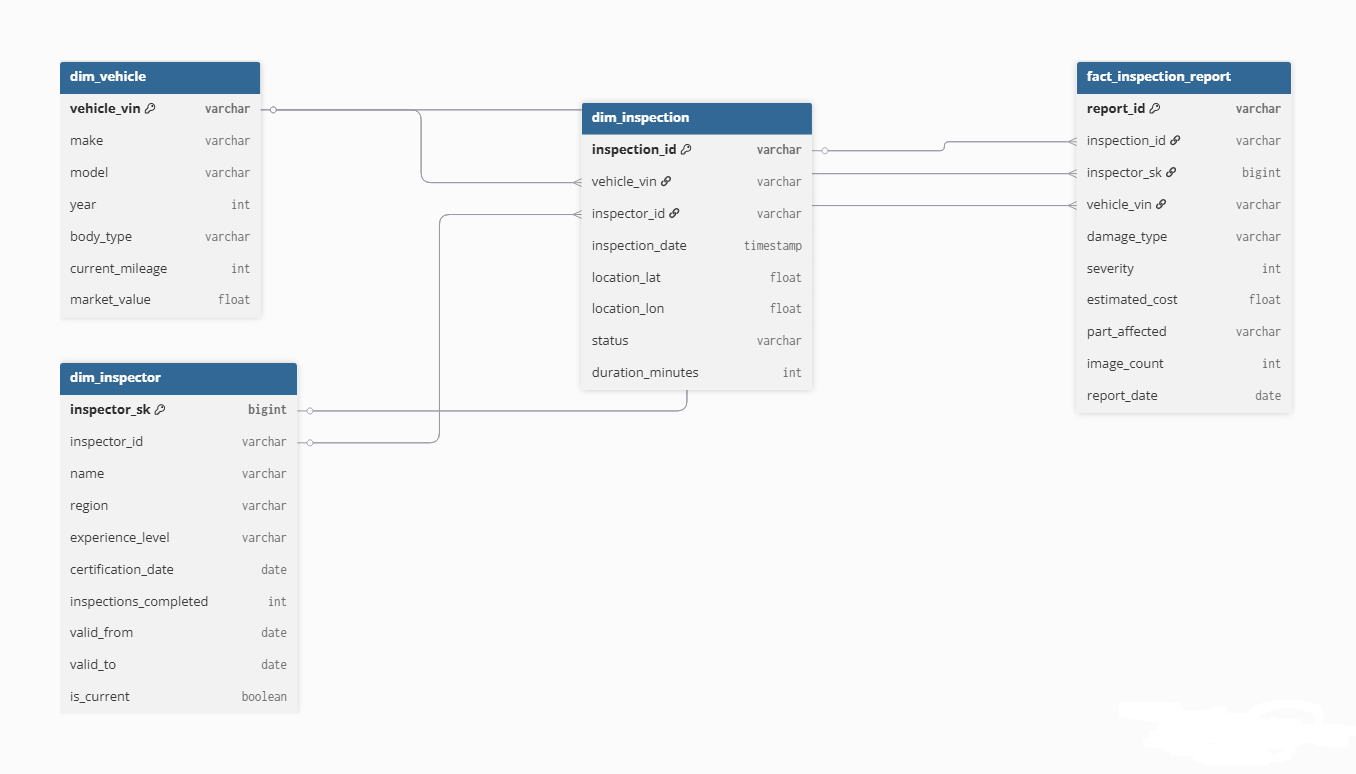

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Spark session with Iceberg catalog
spark = SparkSession.builder \
    .appName("SCD2 with Iceberg") \
    .config("spark.sql.catalog.analytics", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.analytics.type", "hadoop") \
    .config("spark.sql.catalog.analytics.warehouse", "s3://your-bucket/warehouse/") \
    .getOrCreate()

# === Load source data
df_reports = spark.read.option("header", True).csv("reports.csv", inferSchema=True)
df_inspections = spark.read.option("header", True).csv("inspections.csv", inferSchema=True)
df_inspectors = spark.read.option("header", True).csv("inspectors.csv", inferSchema=True)
df_vehicles = spark.read.option("header", True).csv("vehicles.csv", inferSchema=True)

In [ ]:
# Dimension Tables

# dim_vehicle
dim_vehicle = df_vehicles.dropDuplicates(["vin"]).withColumnRenamed("vin", "vehicle_vin")
dim_vehicle.writeTo("analytics.dim_vehicle").createOrReplace()


# dim_inspection
dim_inspection = df_inspections.dropDuplicates(["inspection_id"])
dim_inspection.writeTo("analytics.dim_inspection").createOrReplace()


# dim_inspector

# SCD2 Merge Logic for dim_inspector
from pyspark.sql.functions import current_date

# Step 1: Hash the new snapshot
df_new = df_inspectors \
    .withColumn("record_hash", sha2(concat_ws("||", 
        col("name"), col("region"), col("experience_level"), 
        col("certification_date"), col("inspections_completed")), 256)) \
    .withColumn("valid_from", current_date()) \
    .withColumn("valid_to", lit(None).cast("date")) \
    .withColumn("is_current", lit(True)) \
    .withColumn("inspector_sk", sha2(concat_ws("||", col("inspector_id"), col("certification_date")), 256))

# Step 2: Load current dimension from Iceberg (only active records)

dim_current = spark.read.table("analytics.dim_inspector").filter("is_current = true")

# Step 3: Join to detect changes
df_join = df_new.alias("new").join(
    dim_current.alias("cur"), on="inspector_id", how="left"
)

# Step 4: Identify changed or new records
df_changed = df_join.filter(
    col("cur.record_hash").isNull() |
    (col("new.record_hash") != col("cur.record_hash"))
).select("new.*")

# Step 5: Expire old records
df_expired = df_join.filter(
    col("cur.record_hash").isNotNull() &
    (col("new.record_hash") != col("cur.record_hash"))
).select("cur.*") \
.withColumn("valid_to", current_date()) \
.withColumn("is_current", lit(False))

# Step 6: Merge and append
df_upsert = df_changed.unionByName(df_expired)
df_upsert.writeTo("analytics.dim_inspector").append()

In [ ]:
# Fact Table 

# fact_inspection_report

fact = df_reports \
    .join(df_inspections.select("inspection_id", "vehicle_vin", "inspector_id", "inspection_date"), on="inspection_id", how="left") \
    .join(df_new.select("inspector_id", "inspector_sk"), on="inspector_id", how="left") \
    .withColumn("report_date", col("inspection_date").cast("date")) \
    .withColumn("inspection_sk", sha2(concat_ws("||", col("inspection_id"), col("vehicle_vin")), 256))

fact_inspection_report = fact.select(
    "report_id", "inspection_sk", "inspector_sk", "vehicle_vin",
    "damage_type", "severity", "estimated_cost", "part_affected", "image_count", "report_date"
)

# Write to Iceberg
fact_inspection_report.writeTo("analytics.fact_inspection_report").createOrReplace()

In [ ]:
# Calculate derived metrics:
# Average damage cost by vehicle type
# Inspector performance scores
# Geographic damage patterns
# Time-based inspection trends

In [ ]:
spark.read.table("analytics.fact_inspection_report").createOrReplaceTempView("fact_inspection_report")
spark.read.table("analytics.dim_vehicle").createOrReplaceTempView("dim_vehicle")
spark.read.table("analytics.dim_inspection").createOrReplaceTempView("dim_inspection")
spark.read.table("analytics.dim_inspector").createOrReplaceTempView("dim_inspector")

# Average damage cost by vehicle type
avg_cost_by_type = spark.sql("""
    SELECT
        v.body_type,
        ROUND(AVG(f.estimated_cost), 2) AS avg_estimated_cost
    FROM fact_inspection_report f
    JOIN dim_vehicle v ON f.vehicle_vin = v.vehicle_vin
    GROUP BY v.body_type
    ORDER BY avg_estimated_cost DESC
""")

# Inspector performance scores
inspector_perf = spark.sql("""
    SELECT
        i.inspector_id,
        i.name,
        COUNT(f.report_id) AS total_reports,
        ROUND(SUM(f.estimated_cost) / COUNT(f.report_id), 2) AS performance_score
    FROM fact_inspection_report f
    JOIN dim_inspector i ON f.inspector_sk = i.inspector_sk
    WHERE i.valid_to IS NULL
    GROUP BY i.inspector_id, i.name
    ORDER BY performance_score DESC
""")

# Geographic damage patterns
# Rounding latitude and longtitude to group by
geo_damage = spark.sql("""
    SELECT
        ROUND(ins.location_lat, 1) AS lat_rounded,
        ROUND(ins.location_lon, 1) AS lon_rounded,
        ROUND(AVG(f.estimated_cost), 2) AS avg_estimated_cost
    FROM fact_inspection_report f
    JOIN dim_inspection ins ON f.inspection_id = ins.inspection_id
    GROUP BY ROUND(ins.location_lat, 1), ROUND(ins.location_lon, 1)
    ORDER BY avg_estimated_cost DESC
""")

# Time-based inspection trends
time_trends = spark.sql("""
    SELECT
        YEAR(ins.inspection_date) AS year,
        MONTH(ins.inspection_date) AS month,
        COUNT(f.report_id) AS report_count,
        ROUND(AVG(f.estimated_cost), 2) AS avg_estimated_cost
    FROM fact_inspection_report f
    JOIN dim_inspection ins ON f.inspection_id = ins.inspection_id
    GROUP BY YEAR(ins.inspection_date), MONTH(ins.inspection_date)
    ORDER BY year, month
""")